In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import pymc as pm
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [14]:
ozone = pd.read_csv('Daily_Census_Tract-Level_Ozone_Concentrations__2011-2014_20241205.csv')

In [16]:
pm25 = pd.read_csv('Daily_Census_Tract-Level_PM2.5_Concentrations__2011-2014_20241213.csv')

In [9]:
cdc = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI___2023_Release_20241206.csv')

/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_20605/4185871295.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cdc = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI___2023_Release_20241206.csv')


In [10]:
smoking = pd.read_csv('Race_and_Ethnic_Disparities_in_Cigarette_Smoking_Among_Adults.csv')

## Data Cleaning

In [11]:
rename_mapping = {
    'Hispanic': 'Hispanic',
    'Non-Hispanic AIAN': 'American Indian or Alaska Native',
    'Non-Hispanic Asian': 'Asian or Pacific Islander',
    'Non-Hispanic Black': 'Black, non-Hispanic',
    'Non-Hispanic White': 'White, non-Hispanic'
}

smoking['Comparing (Focus group)'] = smoking['Comparing (Focus group)'].replace(rename_mapping)

smoking['Comparing (Focus group)'].unique()


array(['Hispanic', 'American Indian or Alaska Native',
       'Asian or Pacific Islander', 'Black, non-Hispanic',
       'White, non-Hispanic'], dtype=object)

In [12]:
smoking = smoking[['Year', 'State', 'Demographic', 'Comparing (Focus group)', 'Cigarette Use Prevalence % (Focus group)']]
smoking = smoking.rename(columns={'State' : 'LocationDesc', 'Year': 'YearStart', 'Comparing (Focus group)': 'Stratification1', 'Cigarette Use Prevalence % (Focus group)': 'smoke_percent'})
smoking.head()

,YearStart,LocationDesc,Demographic,Stratification1,smoke_percent
0,2011,Alabama,Race and Ethnicity,Hispanic,27.4
1,2011,Alabama,Race and Ethnicity,Hispanic,27.4
2,2011,Alabama,Race and Ethnicity,Hispanic,27.4
3,2011,Alabama,Race and Ethnicity,Hispanic,27.4
4,2011,Alabama,Race and Ethnicity,American Indian or Alaska Native,51.6


In [13]:
# Replace "No Data" with NaN
smoking['smoke_percent'] = smoking['smoke_percent'].replace("No Data", np.nan)

# Convert the column to float after replacing "No Data"
smoking['smoke_percent'] = smoking['smoke_percent'].astype(float)

# Group-based mean imputation
smoking['smoke_percent'] = smoking['smoke_percent'].fillna(
    smoking.groupby(['LocationDesc', 'YearStart', 'Stratification1'])['smoke_percent'].transform('mean')
)

# If any missing values still exist, fill with the overall mean
smoking['smoke_percent'] = smoking['smoke_percent'].fillna(smoking['smoke_percent'].mean())

print(smoking['smoke_percent'].isna().sum())  # Should print 0 if all missing values are imputed


0


In [14]:
smoking = smoking.groupby(['YearStart', 'LocationDesc', 'Stratification1'])['smoke_percent'].mean().reset_index()
smoking.head()

,YearStart,LocationDesc,Stratification1,smoke_percent
0,2011,Alabama,American Indian or Alaska Native,51.600000
1,2011,Alabama,Asian or Pacific Islander,19.919329
2,2011,Alabama,"Black, non-Hispanic",20.700000
3,2011,Alabama,Hispanic,27.400000
4,2011,Alabama,"White, non-Hispanic",24.900000


In [32]:
def add_state_abbreviation(df, fips_column):
    # Dictionary mapping State FIPS codes to State abbreviations
    state_fips_mapping = {
        '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO', '09': 'CT',
        '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', '16': 'ID', '17': 'IL',
        '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', '24': 'MD',
        '25': 'MA', '26': 'MI', '27': 'MN', '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE',
        '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND',
        '39': 'OH', '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD',
        '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', '54': 'WV',
        '55': 'WI', '56': 'WY'
    }

    # Convert FIPS codes to string if needed and map to state abbreviations
    df['StateAbbreviation'] = df[fips_column].astype(str).str.zfill(2).map(state_fips_mapping)
    
    return df

In [25]:
add_state_abbreviation(ozone, 'statefips')
add_state_abbreviation(pm25, 'statefips')

,year,date,statefips,countyfips,ctfips,latitude,longitude,ds_pm_pred,ds_pm_stdd,StateAbbreviation
0,2011,16JAN2011,36,36067,36067016802,42.86482,-76.22294,7.163089,4.463915,NY
1,2011,16JAN2011,36,36067,36067016901,42.81138,-76.13510,7.112696,4.424604,NY
2,2011,16JAN2011,36,36067,36067016902,42.82194,-75.99122,7.090876,4.403247,NY
3,2011,16JAN2011,36,36067,36067940000,42.94020,-76.15772,7.663674,4.654235,NY
4,2011,16JAN2011,36,36069,36069050101,43.00244,-77.45370,6.471819,4.124993,NY
...,...,...,...,...,...,...,...,...,...,...
105605458,2011,16JAN2011,36,36067,36067016501,42.93499,-76.32041,7.427548,4.472635,NY
105605459,2011,16JAN2011,36,36067,36067016502,42.98960,-76.33489,7.620845,4.552469,NY
105605460,2011,16JAN2011,36,36067,36067016600,42.97702,-76.41428,7.372709,4.600565,NY
105605461,2011,16JAN2011,36,36067,36067016700,42.89961,-76.41221,7.512483,4.645402,NY


In [33]:
def filter_name(df):
    df = df.drop(columns=['statefips', 'date', 'countyfips', 'ctfips'])
    df = df.rename(columns={'StateAbbreviation': 'LocationAbbr', 'year': 'YearStart'})
    return df

In [34]:
pm25 = pm25.dropna()
pm25['statefips'] = pm25['statefips'].astype(int)

In [35]:
ozone = filter_name(ozone)
pm25 = filter_name(pm25)

In [36]:
ozone_yearly = ozone.groupby(['LocationAbbr', 'YearStart']).agg({
    'ds_o3_pred': 'mean',  # Average ozone prediction for the year
    'ds_o3_stdd': 'mean',  # Average standard deviation of ozone
}).reset_index()

ozone_yearly.rename(columns={
    'ds_o3_pred': 'avg_ds_o3_pred',
    'ds_o3_stdd': 'avg_ds_o3_stdd'
}, inplace=True)

In [37]:
pm25_yearly = pm25.groupby(['LocationAbbr', 'YearStart']).agg({
    'ds_pm_pred': 'mean',  # Average pm25 prediction for the year
    'ds_pm_stdd': 'mean',  # Average standard deviation of pm25
}).reset_index()
pm25_yearly.rename(columns={
    'ds_pm_pred': 'avg_ds_pm_pred',
    'ds_pm_stdd': 'avg_ds_pm_stdd'
}, inplace=True)

In [38]:
ozone_yearly.to_csv('ozone_yearly.csv', index = False)
pm25_yearly.to_csv('pm25_yearly.csv', index = False)

In [5]:
ozone_yearly = pd.read_csv('ozone_yearly.csv')
pm25_yearly = pd.read_csv('pm25_yearly.csv')

In [40]:
final_df = cdc[cdc['Question'] == 'Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis among Medicare-eligible persons aged >= 65 years']
final_df = final_df[final_df['DataValueUnit'] == 'cases per 1,000']

In [41]:
def filter_df(df):
    valid_states = [
        'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
        'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
        'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
        'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
        'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
    ]
    
    df_filtered = df[df['StratificationCategory1'] == 'Race/Ethnicity']

    df_filtered = df_filtered[(df_filtered['YearStart'] >= 2011) & (df_filtered['YearEnd'] <= 2014)]
    df_filtered = df_filtered[df_filtered['LocationAbbr'].isin(valid_states)]
    df_filtered = df_filtered.drop(columns=['YearEnd', 'DataSource', 'Response', 'DatavalueFootnote',
                    'StratificationCategory2','Stratification2', 'StratificationCategory3', 'Stratification3', 'ResponseID', 'LocationID',
                    'StratificationCategoryID2', 'Topic', 'QuestionID', 'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1',
                    'StratificationCategoryID2', 'StratificationID2', 'StratificationCategoryID3', 'StratificationID3', 'DataValueFootnoteSymbol', 
                    'DataValueAlt']) 
    return df_filtered

In [42]:
final_df = filter_df(final_df)
final_df.shape

(2000, 13)

In [43]:
merged_df = pd.merge(final_df, ozone_yearly, on=['LocationAbbr', 'YearStart'], how='inner')

In [45]:
final_merged_df = pd.merge(merged_df, pm25_yearly, on=['LocationAbbr', 'YearStart'], how='inner')

In [46]:
# Impute missing values in the DataValue column using group-based mean imputation
final_merged_df['DataValue'] = final_merged_df['DataValue'].fillna(
    final_merged_df.groupby(['LocationDesc', 'YearStart'])['DataValue'].transform('mean')
)

# If any missing values still exist (e.g., due to insufficient group data), fill with overall mean
final_merged_df['DataValue'] = final_merged_df['DataValue'].fillna(final_merged_df['DataValue'].mean())

/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_13992/192126086.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_merged_df['DataValue'] = final_merged_df['DataValue'].fillna(


In [47]:
# Encoding the 'Stratification1' column into numbers using a mapping approach
stratification_mapping = {value: idx for idx, value in enumerate(final_merged_df['Stratification1'].unique())}
final_merged_df['Stratification1_encoded'] = final_merged_df['Stratification1'].map(stratification_mapping)
# Encoding the 'LocationAbbr' column into numbers using a mapping approach
location_mapping = {value: idx for idx, value in enumerate(final_merged_df['LocationAbbr'].unique())}
final_merged_df['LocationAbbr_encoded'] = final_merged_df['LocationAbbr'].map(location_mapping)

In [48]:
final_merged_df = final_merged_df[['YearStart', 'LocationAbbr', 'LocationDesc', 'LocationAbbr_encoded', 'Question', 'DataValueUnit', 'DataValueType', 'DataValue', 'StratificationCategory1', 'Stratification1', 'Stratification1_encoded', 'avg_ds_o3_pred', 'avg_ds_o3_stdd', 'avg_ds_pm_pred', 'avg_ds_pm_stdd']]
final_merged_df = pd.merge(final_merged_df, smoking, on=['LocationDesc', 'YearStart', 'Stratification1'], how='inner')
# Encoding the 'DataValueType' column into numerical values
final_merged_df['DataValueType_encoded'] = final_merged_df['DataValueType'].astype('category').cat.codes

In [29]:
#Loading per capita energy-related carbon dioxide emissions by state
co2 = pd.read_excel('table4.xlsx')
# Reshaping the data into a long format with columns: Year, State, Value
reshaped_data = co2.melt(id_vars=['State'], 
                                var_name='Year', 
                                value_name='Value')
#Filter by year and only keep wanted columns
reshaped_data = reshaped_data[(reshaped_data['Year'] >= 2011) & (reshaped_data['Year'] <= 2014)]
reshaped_data = reshaped_data.rename(columns = {'Value': 'co2_per_capita', 'Year': 'YearStart', 'State': 'LocationDesc'})
reshaped_data.head()

,LocationDesc,YearStart,co2_per_capita
2173,Alabama,2011,26.950973
2174,Alaska,2011,51.253656
2175,Arizona,2011,15.058947
2176,Arkansas,2011,22.890563
2177,California,2011,9.082425


In [51]:
final_merged_df = pd.merge(final_merged_df, reshaped_data, on=['LocationDesc', 'YearStart'], how='inner')

In [52]:
final_merged_df.to_csv('final_merged_df.csv', index = False)

## EDA (first two visualizations only)

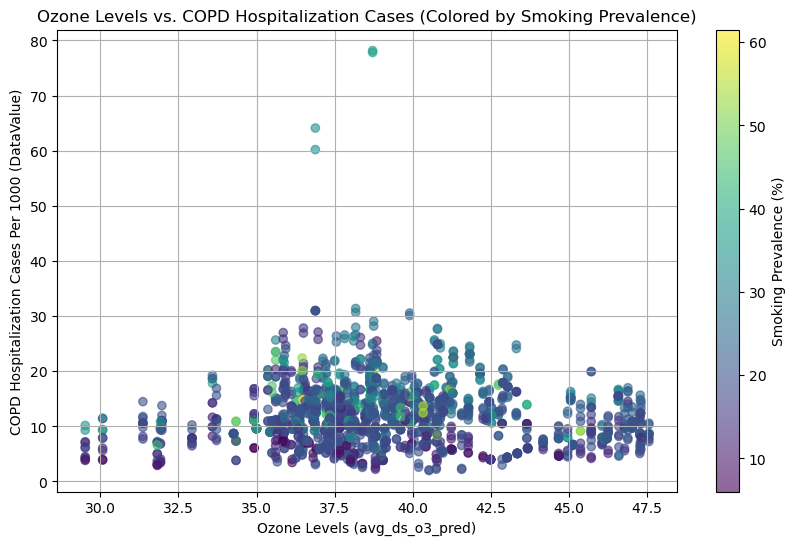

In [58]:
df = final_merged_df

relevant_columns = [
    "DataValue",              # Hospitalization rates for COPD
    "avg_ds_o3_pred",         # Ozone levels
    "avg_ds_pm_pred",         # Particulate matter levels
    "smoke_percent",          
    "co2_per_capita",         
    "Stratification1",
    "DataValueType",          
    "LocationDesc",           
    "YearStart"               
]

filtered_data = df[relevant_columns]

# Visualization 1: Scatter plot of ozone levels vs. hospitalization rates, colored by smoking prevalence
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    filtered_data['avg_ds_o3_pred'], 
    filtered_data['DataValue'], 
    c=filtered_data['smoke_percent'], 
    cmap='viridis', 
    alpha=0.6
)
plt.colorbar(scatter, label='Smoking Prevalence (%)')
plt.title("Ozone Levels vs. COPD Hospitalization Cases (Colored by Smoking Prevalence)")
plt.xlabel("Ozone Levels (avg_ds_o3_pred)")
plt.ylabel("COPD Hospitalization Cases Per 1000 (DataValue)")
plt.grid(True)
plt.show()

/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_13992/2519991601.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


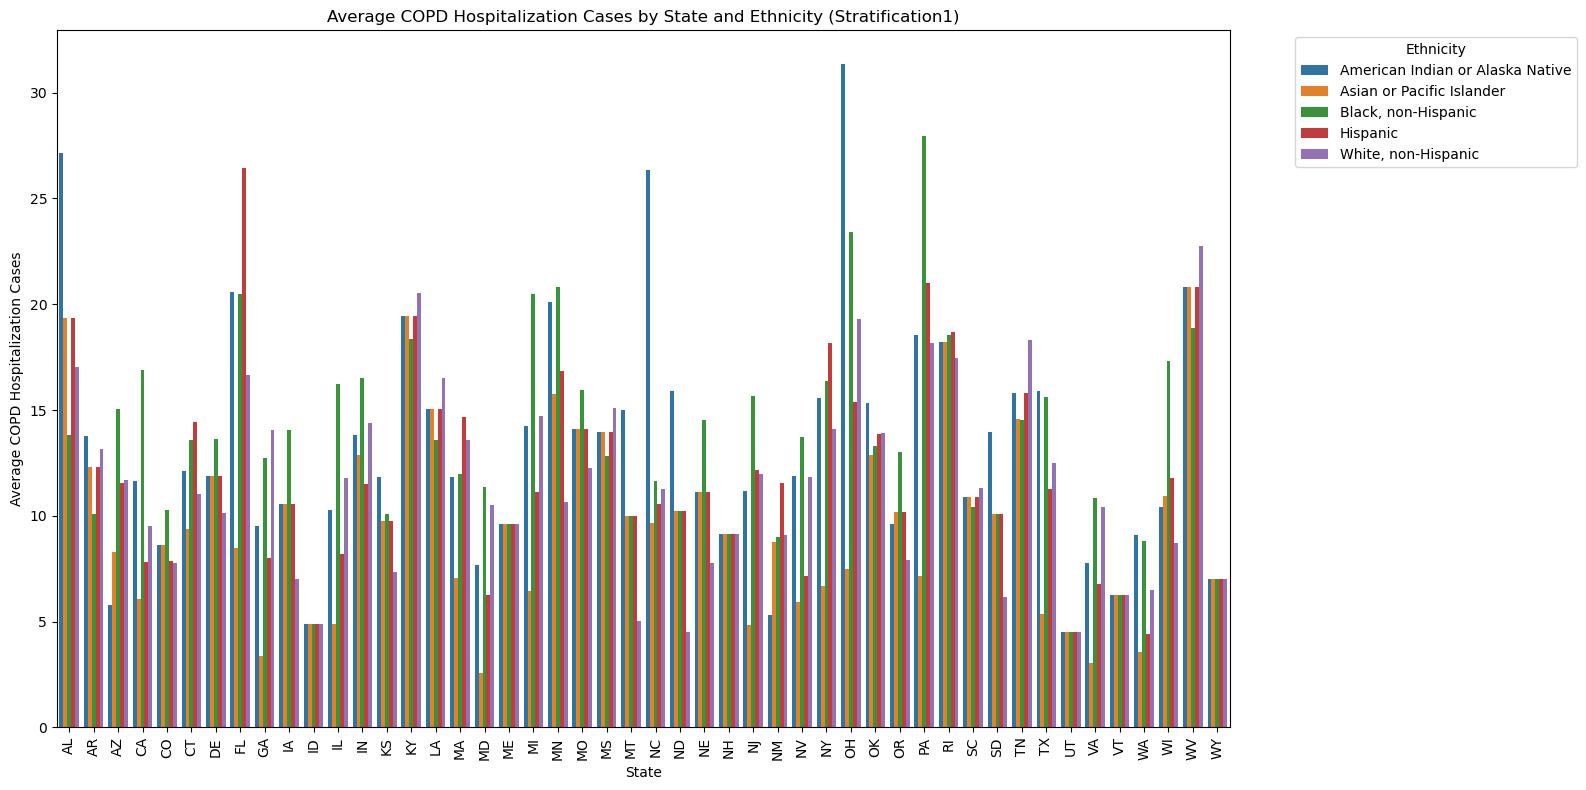

In [59]:
data_new = df
# Filter columns relevant for the analysis
relevant_columns_new = ["DataValue", "LocationAbbr", "Stratification1"]
filtered_data_new = data_new[relevant_columns_new]

# Group the data by location and stratification (ethnicity), calculate the mean hospitalization rate
grouped_data_new = filtered_data_new.groupby(['LocationAbbr', 'Stratification1'])['DataValue'].mean().reset_index()

plt.figure(figsize=(16, 8))
sns.barplot(
    x='LocationAbbr', 
    y='DataValue', 
    hue='Stratification1', 
    data=grouped_data_new, 
    ci=None
)
plt.title("Average COPD Hospitalization Cases by State and Ethnicity (Stratification1)")
plt.xlabel("State")
plt.ylabel("Average COPD Hospitalization Cases")
plt.xticks(rotation=90)
plt.legend(title='Ethnicity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [61]:
ethnicity_stats = grouped_data_new.groupby('Stratification1')['DataValue'].describe()
ethnicity_stats.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
Stratification1,,,,,,,,
Asian or Pacific Islander,48.0,9.669503,4.439218,2.58875,6.405625,9.493958,11.992031,20.800625
"White, non-Hispanic",48.0,11.578281,4.447462,4.51875,7.880313,11.284375,14.162500,22.747500
Hispanic,48.0,11.970098,4.733016,4.41125,8.916875,11.204375,14.479688,26.420000
American Indian or Alaska Native,48.0,13.238898,5.721938,4.51875,9.579948,11.880312,15.617344,31.374479
"Black, non-Hispanic",48.0,13.628277,4.676375,4.51875,10.175937,13.585000,16.261563,27.936250


## GLMs & Nonparametric Methods

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


                 Generalized Linear Model Regression Results                  
Dep. Variable:              DataValue   No. Observations:                 1920
Model:                            GLM   Df Residuals:                     1912
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                         0.17230
Method:                          IRLS   Log-Likelihood:                -5565.5
Date:                Mon, 16 Dec 2024   Deviance:                       306.19
Time:                        01:54:29   Pearson chi2:                     329.
No. Iterations:                    13   Pseudo R-squ. (CS):             0.2491
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

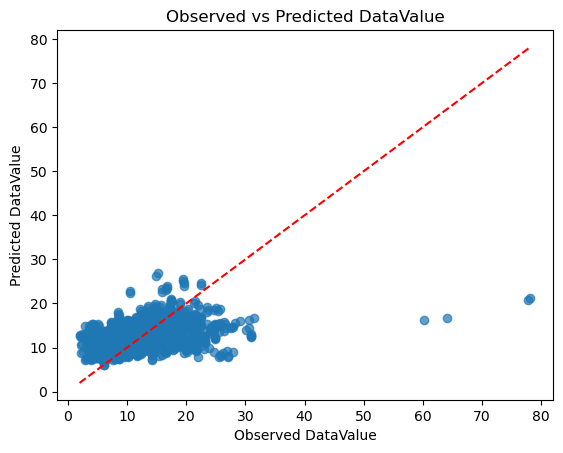

In [54]:
# If 'DataValue' has NaNs, we'll drop them
df = df.dropna(subset=["DataValue", "avg_ds_o3_pred", "avg_ds_pm_pred"])

model = smf.glm(
    formula="DataValue ~ avg_ds_o3_pred + avg_ds_pm_pred + Stratification1_encoded + LocationAbbr_encoded + smoke_percent + DataValueType_encoded + co2_per_capita",
    data=df,
    family=sm.families.Gamma(link=sm.families.links.log())
)

result = model.fit()

print(result.summary())

df["Predicted_DataValue"] = result.predict(df[["avg_ds_o3_pred", "avg_ds_pm_pred", "Stratification1_encoded", 'LocationAbbr_encoded', 'smoke_percent', 'DataValueType_encoded', 'co2_per_capita']])

# Compare observed and predicted values
print(df[["DataValue", "Predicted_DataValue"]].head())

plt.scatter(df["DataValue"], df["Predicted_DataValue"], alpha=0.7)
plt.xlabel("Observed DataValue")
plt.ylabel("Predicted DataValue")
plt.title("Observed vs Predicted DataValue")
plt.plot([df["DataValue"].min(), df["DataValue"].max()], 
         [df["DataValue"].min(), df["DataValue"].max()], 
         color="red", linestyle="--") 
plt.show()

Random Forest MSE: 2.6850598848448795
Random Forest R^2: 0.8856751285830664


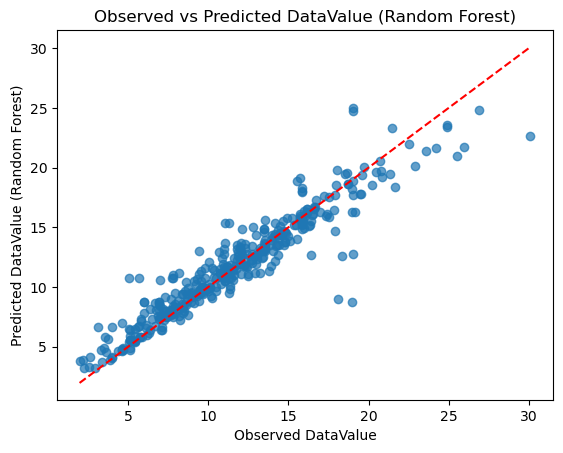

In [55]:
X = df[["avg_ds_o3_pred", "avg_ds_pm_pred", 'Stratification1_encoded', 'LocationAbbr_encoded', 'smoke_percent', 'DataValueType_encoded', 'co2_per_capita']]
y = df["DataValue"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")

df_test = X_test.copy()
df_test["Observed_DataValue"] = y_test
df_test["Predicted_RF_DataValue"] = y_pred_rf

plt.scatter(y_test, y_pred_rf, alpha=0.7)
plt.xlabel("Observed DataValue")
plt.ylabel("Predicted DataValue (Random Forest)")
plt.title("Observed vs Predicted DataValue (Random Forest)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--")  # Reference line
plt.show()

GLM MSE: 19.00043610023177
GLM R^2: 0.19099666034072316
Random Forest MSE: 2.6850598848448795
Random Forest R^2: 0.8856751285830664


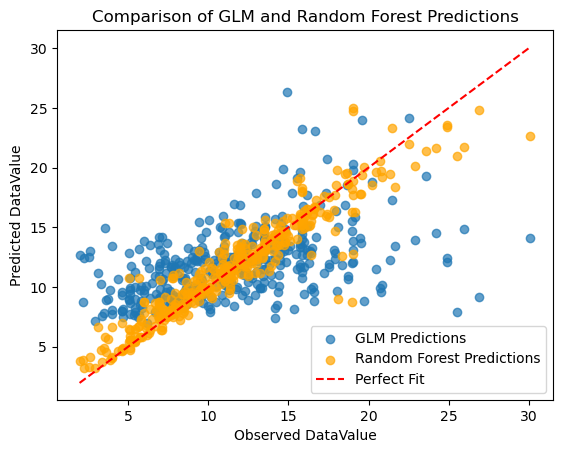

In [56]:
glm_pred = result.predict(X_test)

mse_glm = mean_squared_error(y_test, glm_pred)
r2_glm = r2_score(y_test, glm_pred)

print(f"GLM MSE: {mse_glm}")
print(f"GLM R^2: {r2_glm}")
print(f"Random Forest MSE: {mse_rf}")
print(f"Random Forest R^2: {r2_rf}")

plt.scatter(y_test, glm_pred, alpha=0.7, label="GLM Predictions")
plt.scatter(y_test, y_pred_rf, alpha=0.7, label="Random Forest Predictions", color="orange")
plt.xlabel("Observed DataValue")
plt.ylabel("Predicted DataValue")
plt.title("Comparison of GLM and Random Forest Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Perfect Fit")
plt.legend()
plt.show()

## Causal Inference Data Cleaning

In [15]:
def filter_c(df):
    valid_states = [
        'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
        'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
        'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
        'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
        'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
    ]
    
    df_filtered = df[df['StratificationCategory1'] == 'Race/Ethnicity']

    df_filtered = df_filtered[(df_filtered['YearStart'] >= 2011) & (df_filtered['YearEnd'] <= 2014)]
    df_filtered = df_filtered[df_filtered['LocationAbbr'].isin(valid_states)]
    df_filtered = df_filtered.drop(columns=['YearEnd', 'DataSource', 'Response', 'DatavalueFootnote', 'LowConfidenceLimit', 'HighConfidenceLimit',
                    'GeoLocation', 'Topic', 'TopicID', 'StratificationCategory2','Stratification2', 'StratificationCategory3', 'Stratification3', 'ResponseID', 'LocationID',
                    'StratificationCategoryID2', 'Topic', 'QuestionID', 'DataValueTypeID', 'StratificationCategoryID1', 'StratificationID1',
                    'StratificationCategoryID2', 'StratificationID2', 'StratificationCategoryID3', 'StratificationID3', 'DataValueFootnoteSymbol', 
                    'DataValueAlt']) 
    
    df_filtered = df_filtered[(df_filtered['Question'] == 'Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis among Medicare-eligible persons aged >= 65 years') 
                | (df_filtered['Question'] == 'Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis')]
    df_filtered = df_filtered[df_filtered['DataValueType'] == 'Age-adjusted Rate']
    df_filtered['Normalized_DataValue'] = df_filtered.apply(
        lambda row: row['DataValue'] / 10 if row['DataValueUnit'] == 'cases per 10,000'
        else row['DataValue'] / 100 if row['DataValueUnit'] == 'cases per 100,000'
        else row['DataValue'],  # Keep values unchanged if already in "cases per 1,000"
        axis=1
    )
    df_filtered = df_filtered.drop(columns=['DataValue', 'StratificationCategory1'])
    return df_filtered

In [16]:
def update_unit(value):
    if value == 'cases per 10,000':
        return 'cases per 1,000'
    elif value == 'cases per 100,000':
        return 'cases per 1,000'
    else:
        return value

In [17]:
c_df = filter_c(cdc)
c_df['DataValueUnit'] = c_df['DataValueUnit'].apply(update_unit)

In [18]:
c_df['Normalized_DataValue'].isnull().sum()

599

In [19]:
c_df.head()

,YearStart,LocationAbbr,LocationDesc,Question,DataValueUnit,DataValueType,Stratification1,Normalized_DataValue
242315,2014,CT,Connecticut,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,Asian or Pacific Islander,NaN
242332,2014,AR,Arkansas,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,Asian or Pacific Islander,1.743
242374,2013,AZ,Arizona,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,Hispanic,2.072
242502,2014,CA,California,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,Hispanic,NaN
242692,2014,FL,Florida,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,American Indian or Alaska Native,1.873


In [20]:
# Impute missing values in the Normalized_DataValue column using group-based mean imputation
c_df['Normalized_DataValue'] = c_df['Normalized_DataValue'].fillna(
    c_df.groupby(['LocationDesc', 'YearStart', 'Stratification1'])['Normalized_DataValue'].transform('mean')
)

# Drop rows where Normalized_DataValue is still missing
c_df = c_df.dropna(subset=['Normalized_DataValue'])

# Round the values in the Normalized_DataValue column to 2 decimal points
c_df['Normalized_DataValue'] = c_df['Normalized_DataValue'].round(2)

In [21]:
c_df['DataValueUnit'].value_counts()

DataValueUnit
cases per 1,000    867
Name: count, dtype: int64

In [22]:
filtered_cdc = cdc[
    (cdc['Stratification1'] == 'Overall') &
    (cdc['Topic'] == 'Chronic Obstructive Pulmonary Disease') &
    (cdc['YearStart'] >= 2011) &
    (cdc['YearStart'] <= 2014) &
    (
        (cdc['Question'] == 'Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis among Medicare-eligible persons aged >= 65 years') |
        (cdc['Question'] == 'Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis')
    ) &
    (cdc['DataValueType'] == 'Age-adjusted Rate')
]
filtered_cdc['Normalized_DataValue'] = filtered_cdc.apply(
    lambda row: row['DataValue'] / 10 if row['DataValueUnit'] == 'cases per 10,000'
    else row['DataValue'] / 100 if row['DataValueUnit'] == 'cases per 100,000'
    else row['DataValue'],  # Keep values unchanged if already in "cases per 1,000"
    axis=1
)
filtered_cdc = filtered_cdc.groupby(
    ['YearStart', 'LocationAbbr', 'LocationDesc', 'DataValueType']
).agg(
    Normalized_DataValue=('Normalized_DataValue', 'mean')  # Calculate mean for the group
).reset_index()

valid_states = [
        'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
        'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
        'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
        'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
        'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
    ]

filtered_cdc = filtered_cdc[filtered_cdc['LocationAbbr'].isin(valid_states)]

/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_20605/1496288751.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_cdc['Normalized_DataValue'] = filtered_cdc.apply(


In [23]:
merge_smoke = pd.merge(c_df, smoking, on=['YearStart', 'LocationDesc', 'Stratification1'], how='inner')
merge_smoke.head()

,YearStart,LocationAbbr,LocationDesc,Question,DataValueUnit,DataValueType,Stratification1,Normalized_DataValue,smoke_percent
0,2014,CT,Connecticut,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,Asian or Pacific Islander,5.08,19.919329
1,2014,AR,Arkansas,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,Asian or Pacific Islander,1.74,19.919329
2,2013,AZ,Arizona,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,Hispanic,2.07,16.900000
3,2014,CA,California,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,Hispanic,7.07,11.400000
4,2014,FL,Florida,Hospitalization for chronic obstructive pulmon...,"cases per 1,000",Age-adjusted Rate,American Indian or Alaska Native,1.87,19.919329


In [24]:
aggregated_df = merge_smoke.groupby(['YearStart', 'LocationAbbr', 'LocationDesc', 'DataValueType']).agg(
    Normalized_DataValue=('Normalized_DataValue', 'mean'),  # Aggregated COPD rates (mean)
    smoking_percent=('smoke_percent', 'mean')  # Aggregated smoking prevalence (mean)
).reset_index()
aggregated_df.head()

,YearStart,LocationAbbr,LocationDesc,DataValueType,Normalized_DataValue,smoking_percent
0,2011,AK,Alaska,Age-adjusted Rate,10.360000,29.250000
1,2011,AL,Alabama,Age-adjusted Rate,16.805000,22.800000
2,2011,AR,Arkansas,Age-adjusted Rate,14.706667,29.233333
3,2011,AZ,Arizona,Age-adjusted Rate,13.336000,20.443866
4,2011,CA,California,Age-adjusted Rate,11.518000,15.700000


In [25]:
merged_final = pd.merge(
    aggregated_df,  # The dataframe with aggregated smoking prevalence and COPD rates
    filtered_cdc,   # The dataframe with updated `Normalized_DataValue`
    on=['YearStart', 'LocationAbbr', 'LocationDesc', 'DataValueType'],
    how='left',  # Retain all rows from aggregated_df and replace where matches exist
    suffixes=('', '_filtered') 
)

# Replacing `Normalized_DataValue` with values from `filtered_cdc` where available
merged_final['Normalized_DataValue'] = merged_final['Normalized_DataValue_filtered'].combine_first(merged_final['Normalized_DataValue'])

merged_final.drop(columns=['Normalized_DataValue_filtered'], inplace=True)
merged_final

,YearStart,LocationAbbr,LocationDesc,DataValueType,Normalized_DataValue,smoking_percent
0,2011,AK,Alaska,Age-adjusted Rate,7.3600,29.250000
1,2011,AL,Alabama,Age-adjusted Rate,18.4100,22.800000
2,2011,AR,Arkansas,Age-adjusted Rate,13.2400,29.233333
3,2011,AZ,Arizona,Age-adjusted Rate,13.8700,20.443866
4,2011,CA,California,Age-adjusted Rate,10.6200,15.700000
...,...,...,...,...,...,...
195,2014,VT,Vermont,Age-adjusted Rate,4.4625,15.900000
196,2014,WA,Washington,Age-adjusted Rate,3.5170,19.720000
197,2014,WI,Wisconsin,Age-adjusted Rate,5.8345,24.063866
198,2014,WV,West Virginia,Age-adjusted Rate,12.8820,27.333333


In [26]:
with_ozone = pd.merge(merged_final, ozone_yearly, on=['LocationAbbr', 'YearStart'], how='inner')
with_pm25 = pd.merge(with_ozone, pm25_yearly, on=['LocationAbbr', 'YearStart'], how='inner')
with_pm25.head()

,YearStart,LocationAbbr,LocationDesc,DataValueType,Normalized_DataValue,smoking_percent,avg_ds_o3_pred,avg_ds_o3_stdd,avg_ds_pm_pred,avg_ds_pm_stdd
0,2011,AL,Alabama,Age-adjusted Rate,18.41,22.800000,41.188464,5.419946,10.696324,3.159462
1,2011,AR,Arkansas,Age-adjusted Rate,13.24,29.233333,40.861139,5.592043,10.597298,3.221463
2,2011,AZ,Arizona,Age-adjusted Rate,13.87,20.443866,46.884941,5.010064,7.929366,3.072249
3,2011,CA,California,Age-adjusted Rate,10.62,15.700000,39.968547,4.327457,10.431304,2.803872
4,2011,CO,Colorado,Age-adjusted Rate,10.15,20.333333,47.024679,5.236257,6.438695,2.314446


In [27]:
median_income = pd.read_csv('median_income.csv')
median_income.head()

,LocationDesc,YearStart,MedianIncome
0,Alabama,2011,43600.0
1,Alaska,2011,71500.0
2,Arizona,2011,49200.0
3,Arkansas,2011,40800.0
4,California,2011,60400.0


In [30]:
with_income = pd.merge(with_pm25, median_income, on=['LocationDesc', 'YearStart'], how='inner')
causal_final = pd.merge(with_income, reshaped_data, on=['LocationDesc', 'YearStart'], how='inner')

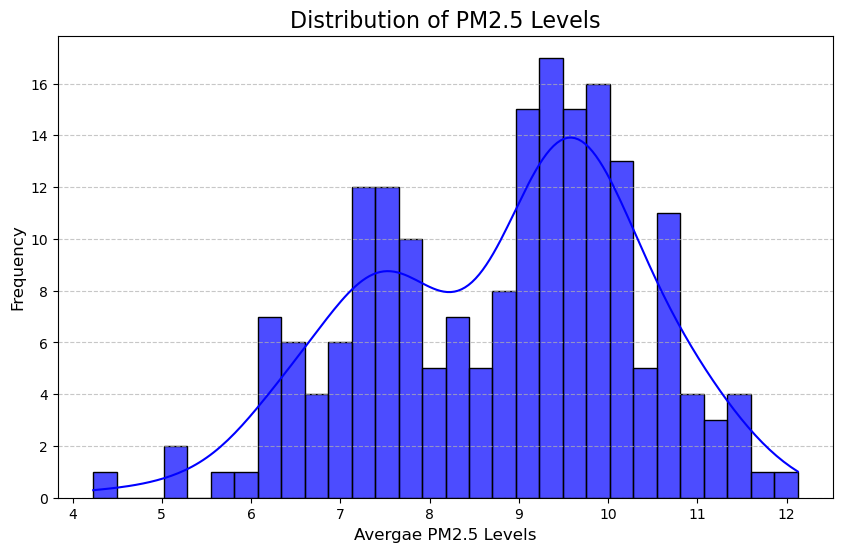

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(
    data=causal_final,
    x='avg_ds_pm_pred',  # PM2.5 levels
    bins=30,
    kde=True,
    color='blue',
    alpha=0.7
)
plt.title('Distribution of PM2.5 Levels', fontsize=16)
plt.xlabel('Avergae PM2.5 Levels', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [32]:
causal_final['avg_ds_pm_pred'].describe()

count    192.000000
mean       8.816033
std        1.518535
min        4.231558
25%        7.572576
50%        9.159114
75%        9.886273
max       12.126285
Name: avg_ds_pm_pred, dtype: float64

In [33]:
median_pm25 = causal_final['avg_ds_pm_pred'].median()

# Binarize PM2.5 levels using the median as the threshold
causal_final['high_pm25'] = (causal_final['avg_ds_pm_pred'] > median_pm25).astype(int)

binary_distribution = causal_final['high_pm25'].value_counts()
binary_distribution

high_pm25
1    96
0    96
Name: count, dtype: int64

In [34]:
median_pm25

9.159114021285932

In [35]:
causal_final.head()

,YearStart,LocationAbbr,LocationDesc,DataValueType,Normalized_DataValue,smoking_percent,avg_ds_o3_pred,avg_ds_o3_stdd,avg_ds_pm_pred,avg_ds_pm_stdd,MedianIncome,co2_per_capita,high_pm25
0,2011,AL,Alabama,Age-adjusted Rate,18.41,22.800000,41.188464,5.419946,10.696324,3.159462,43600.0,26.950973,1
1,2011,AR,Arkansas,Age-adjusted Rate,13.24,29.233333,40.861139,5.592043,10.597298,3.221463,40800.0,22.890563,1
2,2011,AZ,Arizona,Age-adjusted Rate,13.87,20.443866,46.884941,5.010064,7.929366,3.072249,49200.0,15.058947,0
3,2011,CA,California,Age-adjusted Rate,10.62,15.700000,39.968547,4.327457,10.431304,2.803872,60400.0,9.082425,1
4,2011,CO,Colorado,Age-adjusted Rate,10.15,20.333333,47.024679,5.236257,6.438695,2.314446,58400.0,17.988613,0


In [36]:
causal_final.to_csv('causal_final.csv', index = False)
causal_final = pd.read_csv('causal_final.csv')

## More EDA

/var/folders/s_/yf9hp5d54l9bjwvwpjcwbk200000gn/T/ipykernel_20605/1096839056.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=causal_final, x='high_pm25', y='Normalized_DataValue', palette='pastel')


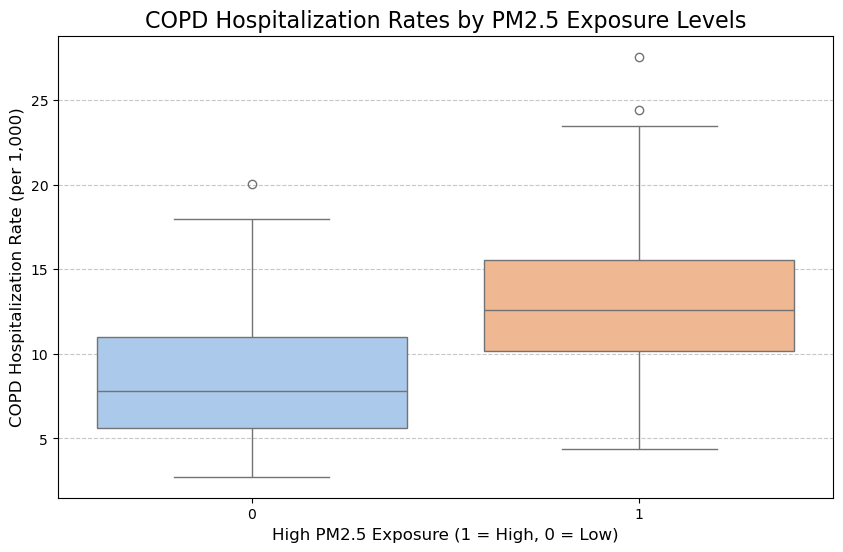

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=causal_final, x='high_pm25', y='Normalized_DataValue', palette='pastel')

plt.title('COPD Hospitalization Rates by PM2.5 Exposure Levels', fontsize=16)
plt.xlabel('High PM2.5 Exposure (1 = High, 0 = Low)', fontsize=12)
plt.ylabel('COPD Hospitalization Rate (per 1,000)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("copd_pm25_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1200x800 with 0 Axes>

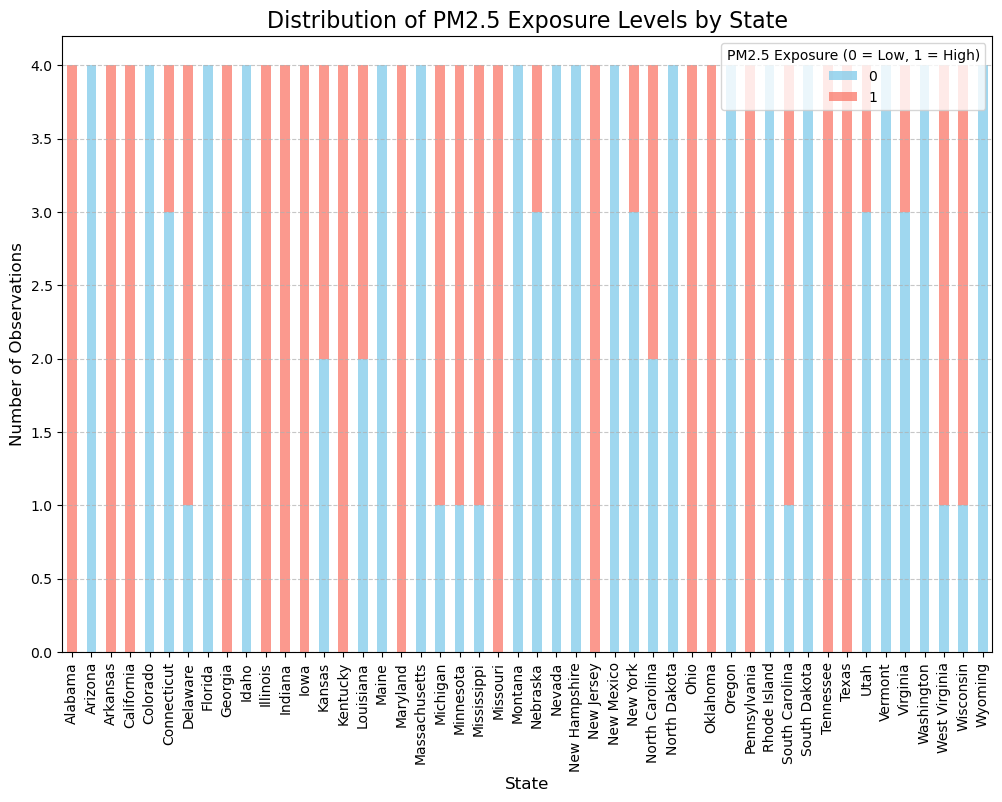

In [99]:
# Count the number of observations for each PM2.5 exposure level by state
pm25_state_counts = pd.crosstab(causal_final['LocationDesc'], causal_final['high_pm25'])


plt.figure(figsize=(12, 8))
pm25_state_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'], alpha=0.8, figsize=(12, 8))

plt.title('Distribution of PM2.5 Exposure Levels by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Observations', fontsize=12)
plt.legend(title='PM2.5 Exposure (0 = Low, 1 = High)', loc='upper right')
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("barchart.png", dpi=300, bbox_inches='tight')
plt.show()

## Causal Inference

In [100]:
model = smf.ols(
    formula="Normalized_DataValue ~ high_pm25 + smoking_percent + avg_ds_o3_pred + MedianIncome + co2_per_capita",
    data=causal_final
).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     Normalized_DataValue   R-squared:                       0.293
Model:                              OLS   Adj. R-squared:                  0.274
Method:                   Least Squares   F-statistic:                     15.39
Date:                  Mon, 16 Dec 2024   Prob (F-statistic):           1.18e-12
Time:                          02:14:51   Log-Likelihood:                -533.30
No. Observations:                   192   AIC:                             1079.
Df Residuals:                       186   BIC:                             1098.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.

In [101]:
print("ATE from Regression:", model.params['high_pm25'])

ATE from Regression: 3.9935989860299648


Bootstrap ATE Estimate: 4.418
95% Confidence Interval: [3.250, 5.513]


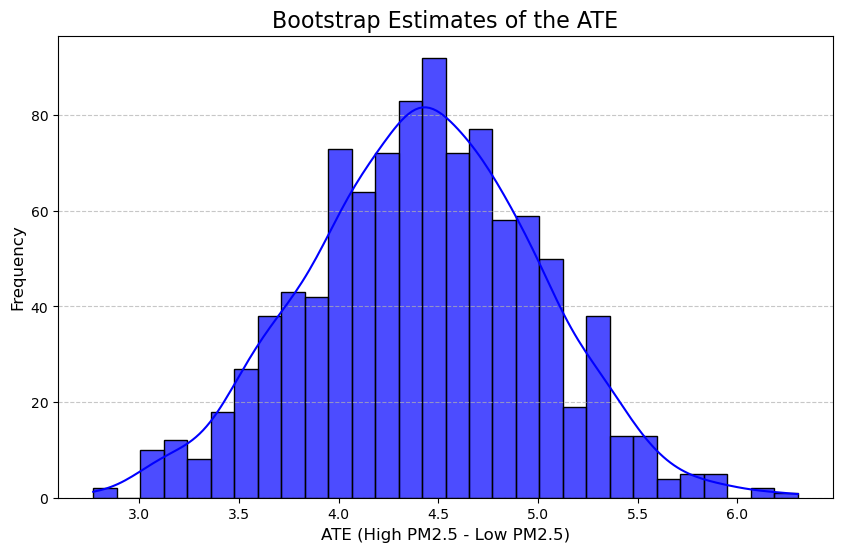

In [102]:
# Function to calculate bootstrap ATE
def bootstrap_ate(data, treatment_col, outcome_col, n_iterations=500):
    """
    Perform bootstrap to estimate the Average Treatment Effect (ATE) and calculate confidence intervals.
    Args:
        data (pd.DataFrame): The dataset containing treatment and outcome columns.
        treatment_col (str): The name of the binary treatment column.
        outcome_col (str): The name of the outcome column.
        n_iterations (int): Number of bootstrap iterations.

    Returns:
        np.array: ATE estimates from bootstrap samples.
    """
    ate_estimates = []

    for _ in range(n_iterations):
        # Resample with replacement
        bootstrap_sample = data.sample(frac=1, replace=True)

        # Split into treatment and control groups
        treatment_group = bootstrap_sample[bootstrap_sample[treatment_col] == 1]
        control_group = bootstrap_sample[bootstrap_sample[treatment_col] == 0]

        # Calculate mean outcomes
        treatment_mean = treatment_group[outcome_col].mean()
        control_mean = control_group[outcome_col].mean()

        # Calculate ATE
        ate = treatment_mean - control_mean
        ate_estimates.append(ate)

    return np.array(ate_estimates)

n_iterations = 1000
ate_estimates = bootstrap_ate(causal_final, treatment_col='high_pm25', outcome_col='Normalized_DataValue', n_iterations=n_iterations)

# Calculate 95% confidence interval
lower_bound = np.percentile(ate_estimates, 2.5)
upper_bound = np.percentile(ate_estimates, 97.5)
mean_ate = np.mean(ate_estimates)

print(f"Bootstrap ATE Estimate: {mean_ate:.3f}")
print(f"95% Confidence Interval: [{lower_bound:.3f}, {upper_bound:.3f}]")

plt.figure(figsize=(10, 6))
sns.histplot(ate_estimates, kde=True, bins=30, color='blue', alpha=0.7)
plt.title('Bootstrap Estimates of the ATE', fontsize=16)
plt.xlabel('ATE (High PM2.5 - Low PM2.5)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("boostrap.png", dpi=300, bbox_inches='tight')
plt.show()


In [105]:
X = causal_final[['smoking_percent', 'avg_ds_o3_pred', 'avg_ds_o3_stdd', 'MedianIncome', 'co2_per_capita']]
y = causal_final['high_pm25']

# Fit logistic regression model to estimate propensity scores
logreg = LogisticRegression()
logreg.fit(X, y)

causal_final['propensity_score'] = logreg.predict_proba(X)[:, 1]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [107]:
# Calculate IPW weights
causal_final['ipw_weight'] = causal_final.apply(
    lambda row: 1 / row['propensity_score'] if row['high_pm25'] == 1 else 1 / (1 - row['propensity_score']),
    axis=1
)

In [110]:
# Separate treated and control groups
treated = causal_final[causal_final['high_pm25'] == 1]
control = causal_final[causal_final['high_pm25'] == 0]

# Calculate weighted means
weighted_mean_treated = (treated['Normalized_DataValue'] * treated['ipw_weight']).sum() / treated['ipw_weight'].sum()
weighted_mean_control = (control['Normalized_DataValue'] * control['ipw_weight']).sum() / control['ipw_weight'].sum()

# Calculate ATE
ate_ipw = weighted_mean_treated - weighted_mean_control
print(f"ATE (IPW): {ate_ipw}")

ATE (IPW): 3.4443946554729923
